<a href="https://colab.research.google.com/github/Anikate-De/TensorFlow-Deep-Learning/blob/main/Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Transfer Learning with TensorFlow

## What is **Transfer Learning**?

***Transfer learning*** is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

The "second task" may be a different but related problem on which the model being used promises fruition.

There are two primary benefits of Transfer Learning -
 - Using an pre-built Neural Network Architecture instead of creating one from scratch
 - Using less data to train the Models as they have aleady been trained on an existing dataset (which is related to the current problem) and hold their features and patterns.

----

**Strategies of Transfer Learning -**
 - Feature Extraction
 - Fine-tuning
 - Scaling Up

## Feature Extraction

In this strategy of Transfer Learning, we use a model that has already been created and trained on a dataset similar to our problem, and also yields good results. We put the weight, biases and features of the model to use. Thus, we may not need to train our model with the complete training dataset. Only a small fraction of it should be enough to render great accuracy.

We use TensorFlow's dedicated platform, [TensorFlow Hub](https://tfhub.dev/) to get models for our problems.

We can filter the models based on our needs and use them in creating our models with the `tensorflow_hub` package.

### Using ImageNet-Trained Models

For our problem, of classifying pictures of food into 10 different classes, we are going to use models on TFHub which have been trained on the [ImageNet](https://www.image-net.org/) dataset. This dataset consists of millions of images of various objects, some of which are also of food items.

We use Feature Vector models as they have been trained specifically to learn various features of images in the `ImageNet` dataset.

### Download and Prepare Data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [ ]:
import zipfile

zipref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zipref.extractall()
zipref.close()

Walk the directories to see the downloaded data and its heirarchies

In [ ]:
import os

for dirpath, dirname, filenames in os.walk('10_food_classes_10_percent/'):
  if len(dirname) > 0:
    print(f'Found {len(dirname)} directories in {dirpath}')
  if len(filenames) > 0:
    print(f'Found {len(filenames)} files in {dirpath}')

In [ ]:
class_names = sorted(os.listdir('10_food_classes_10_percent/train'))
num_classes = len(class_names)
class_names, num_classes

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimp
import random

# Create a function to show random images
def view_random_images(target_dir, target_class, num_images = 1):
  """
    Selects Random Images based on the `target_dir` parent directory and `target_class` child directory

    Params:
      (str) target_dir: The path of the parent directory which holds a list of child directories.
      (str) target_class: The name of the child directory which contains images
      (int) num_images: The number of images to display in the output, maximum allowed number is `10`.

    Returns:
      None

    Outputs:
      (Conditional) Warning Statement
      A matplotlib.pyplot figure of <num_images> images.
  """
  target_folder = target_dir + target_class

  if (num_images > 10):
    print('A maximum of 10 images is allowed')
    num_images = 10

  # Get a random image path
  random_images = random.sample(os.listdir(target_folder), num_images)

  plt.figure(figsize = (18, 6))

  for index in range(len(random_images)):
    # Read the image using MatplotLib
    img = mpimp.imread(target_folder + '/' + random_images[index])
    plt.subplot(2, 5, index + 1)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')

In [ ]:
import random
view_random_images(target_dir='10_food_classes_10_percent/train/',
                        target_class=random.choice(class_names),
                   num_images = 10)

In [ ]:
view_random_images(target_dir='10_food_classes_10_percent/train/',
                        target_class=random.choice(class_names),
                   num_images = 10)

Use `ImageDataGenerator` to get images from training and testing directories

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(4)

# Rescale the data and create data generator instances
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Import data and turn it into batches
train_data = train_datagen.flow_from_directory('10_food_classes_10_percent/train',
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               class_mode = 'categorical',
                                               seed = 4)
test_data = test_datagen.flow_from_directory('10_food_classes_10_percent/test',
                                               batch_size = 32,
                                               target_size = (224, 224),
                                               class_mode = 'categorical',
                                               seed = 4)

### TensorBoard

[**TensorBoard**](https://tensorboard.dev/) is a useful tool that lets you evaluate and compare models during and after experimentation.

After a certain point, it becomes tedious to scroll all the way up and find different models, their architectures and summaries. TensorBoard helps us deal with this problem.

The platform [Weights & Biases](https://wandb.ai/site) can also be combined with TensorBoard to provide a more detailed report after each experiment.

To use TensordBoard, we need to make a callback that will be called during each epoch of training of the model. This can be done with the help of the pre-defined TensorBoard callback in `keras.callbacks`


In [ ]:
import datetime

log_dir="logs/efficientnet/b7/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

efficientnet_b7_tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

### Create Models

In [ ]:
import tensorflow_hub as hub

efficientnet_b7_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
                   trainable=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

efficientnet_b7_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

efficientnet_b7_history = efficientnet_b7_model.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      # callbacks = [efficientnet_b7_tensorboard_callback])
)

In [ ]:
import datetime
import tensorflow_hub as hub

log_dir="logs/mobilenet/v2_100/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

mobilenet_v2_100_tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

mobilenet_v2_100_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
                   trainable=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

mobilenet_v2_100_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

mobilenet_v2_100_history = mobilenet_v2_100_model.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      # callbacks = [mobilenet_v2_100_tensorboard_callback])
)

In [ ]:
import datetime
import tensorflow_hub as hub

log_dir="logs/resnet/v1_50/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

resnet_v1_50_tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

resnet_v1_50_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/feature_vector/1",
                   trainable=False),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

resnet_v1_50_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

resnet_v1_50_history = resnet_v1_50_model.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      # callbacks = [resnet_v1_50_tensorboard_callback])
)

### Upload the TensorBoard Logs

After successful experimentation, you can upload the TensorFlow logs folder to the platform.

> **Note:** Once the data is pushed online, it is available to the public and hence, no private datasets should be pushed.

In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "Image Classification with Transfer Learning" \
  --description "Using prominent Image Feature Vector DL models from TensorFlow Hub to categorically classify images of food and comparing the results." \
  --one_shot

Plot the loss and accuracy Curves v/s epochs

### Evaluate Models

In [2]:
import pandas as pd

def plot_curves(history, loss_function):
  """

    Plots Curves using model training history.

    Params:
      (tensorflow.keras.callbacks.History) history: The History object that is obtained upon fitting the model.
      (str) loss_function: The Loss Function that has been used to calculate the loss of the model.

    Returns:
      None

    Output:
      A matplotlib.pyplot figure of <num_images> images.

  """

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  pd.DataFrame({'Loss': loss, 'Validation Loss': val_loss}).plot(title = 'Loss Curves', xlabel = 'Epoch', ylabel = loss_function)
  pd.DataFrame({'Accuracy': accuracy, 'Validation Accuracy': val_accuracy}).plot(title = 'Accuracy Curves', xlabel = 'Epoch', ylabel = 'Accuracy')

In [ ]:
plot_curves(efficientnet_b7_history, 'Categorical CrossEntropy')

In [ ]:
plot_curves(mobilenet_v2_100_history, 'Categorical CrossEntropy')

In [ ]:
plot_curves(resnet_v1_50_history, 'Categorical CrossEntropy')

### Make & Display Predictions

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimp
import random

# Create a function to show random images
def predict_random_images_multiclass(target_dir, model, class_names, num_images = 1, target_classes = None):
  """

    Predicts a given number of random images with a model and outputs a plot of the images along with the results in brief.

    Params:
      (str) target_dir: The path of the parent directory which holds a list of child directories.
      (tensorflow.keras.Model) model: The model that should be used to make the predictions.
      (list<str>) class_names: A list of names of all the classes that can be predicted by the model. Must be in order of the predictions made, otherwise incorrect results would be rendered.
      (int) num_images: The number of images to display in the output, maximum allowed number is `10`. Default value is 1.
      (list<str> | None) target_classes: A list of the names of the target child directories (or classes) to randomly select the images from. If None, the list `class_names` is used for this purpose.

    Returns:
      None

    Outputs:
      (Conditional) Warning Statement
      A matplotlib.pyplot figure of <num_images> images.

  """

  if (num_images > 10):
    print('A maximum of 10 images is allowed')
    num_images = 10

  if target_classes == None:
    target_classes = class_names

  plt.figure(figsize = (18, 8))

  for i in range(num_images):
    random_class = random.choice(target_classes)
    target_path = target_dir + random_class
    img = mpimp.imread(target_path + '/' + random.choice(os.listdir(path = target_path)))
    img = tf.image.resize(img, size = [224, 224])
    img /= 255

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)


    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0), verbose = 0)

    # Get the predicted class
    pred_class = class_names[pred.argmax()]

    if pred_class == random_class:
      color = 'green'
    else:
      color = 'red'

    plt.title(f'Prediction: {pred_class.title()}\nTrue: {random_class.title()}\nConfidence: {(tf.reduce_max(pred) * 100):.2f}%', fontdict = {'color' : color})
    plt.axis('off')

In [ ]:
predict_random_images_multiclass(target_dir = '10_food_classes_10_percent/test/', model = efficientnet_b7_model, class_names = class_names, num_images = 10)

In [ ]:
predict_random_images_multiclass(target_dir = '10_food_classes_10_percent/test/', model = mobilenet_v2_100_model, class_names = class_names, num_images = 10)

In [ ]:
predict_random_images_multiclass(target_dir = '10_food_classes_10_percent/test/', model = resnet_v1_50_model, class_names = class_names, num_images = 10)

## Fine-Tuning

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

Top Layers are unfrozen and tweaked with our own dataset. Bottom Layers may still remain frozen.

Fine Tuning a model usually requires a larger dataset than Feature Extraction.

In [ ]:
train_data_10_perc = tf.keras.utils.image_dataset_from_directory('10_food_classes_10_percent/train',
                                                                 image_size = (224, 224),
                                                                 label_mode = 'categorical')

test_data_10_perc = tf.keras.utils.image_dataset_from_directory('10_food_classes_10_percent/test',
                                                                 image_size = (224, 224),
                                                                 label_mode = 'categorical')

In [ ]:
train_data_10_perc

In [ ]:
train_data_10_perc.class_names

In [ ]:
for images, labels in train_data_10_perc.take(1):
  print(images, labels)

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = EfficientNetB7(include_top = False)
base_model.trainable = False

inputs = tf.keras.Input(shape = (224, 224, 3))

x = base_model(inputs)
x = GlobalAveragePooling2D()(x)

outputs = Dense(10, activation = 'softmax')(x)

model_feat_ext = tf.keras.Model(
    inputs,
    outputs
)

In [ ]:
model_feat_ext.compile(loss = 'categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = ['accuracy'])

In [ ]:
history_feat_ext = model_feat_ext.fit(train_data_10_perc,
                                          epochs = 5,
                                          steps_per_epoch = len(train_data_10_perc),
                                          validation_data = test_data_10_perc,
                                          validation_steps = len(test_data_10_perc))

In [ ]:
model_feat_ext.evaluate(test_data_10_perc)

In [ ]:
input_tensor = tf.random.normal((1, 4, 4, 3))

print(f'Random Tensor: {input_tensor}')

avg_pooled_tensor = GlobalAveragePooling2D()(input_tensor)

print(f'Global Average Pooled Tensor: {avg_pooled_tensor}')

In [ ]:
from tensorflow.keras.layers import GlobalMaxPooling2D

max_pooled_tensor = GlobalMaxPooling2D()(input_tensor)

print(f'Max Average Pooled Tensor: {max_pooled_tensor}')

In [ ]:
tf.reduce_mean(input_tensor, axis = [1,2])

In [ ]:
tf.reduce_max(input_tensor, axis = [1,2])

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2)
], name = 'data_augmentation')

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def show_image(target):
  class_name = random.choice(class_names)
  target = target + class_name
  img = mpimg.imread(target + '/' + random.choice(os.listdir(target)))

  plt.axis(False)
  plt.title(f'Original Image of {class_name}')
  plt.imshow(img)
  plt.show()

  print()

  plt.axis(False)
  plt.title(f'Augmented Image of {class_name}')
  aug_img = data_augmentation(img)
  plt.imshow(aug_img / 255)
  plt.show()


In [ ]:
show_image('10_food_classes_10_percent/train/')

In [ ]:
show_image('10_food_classes_10_percent/train/')

In [ ]:
checkpoint_path = "model_checkpoints/checkpoint"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose = 1)


In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = EfficientNetB7(include_top = False)
base_model.trainable = False

inputs = tf.keras.Input(shape = (224, 224, 3), name = 'input_layer')

x = data_augmentation(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)

outputs = Dense(10, activation = 'softmax')(x)

model_2 = tf.keras.Model(
    inputs,
    outputs
)

In [ ]:
model_2.compile(loss = 'categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = ['accuracy'])

In [ ]:
initial_epochs = 5

history_2 = model_2.fit(train_data_10_perc,
                        epochs = initial_epochs,
                        steps_per_epoch = len(train_data_10_perc),
                        validation_data = test_data_10_perc,
                        validation_steps = len(test_data_10_perc),
                        callbacks = [model_checkpoint_callback]
                        )

In [ ]:
last_results = model_2.evaluate(test_data_10_perc)
last_results

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
loaded_results = model_2.evaluate(test_data_10_perc)
loaded_results

In [ ]:
import numpy as np

np.isclose(np.array(last_results), np.array(loaded_results))

In [ ]:
for layer in model_2.layers:
  print(layer, layer.trainable)

In [ ]:
len(model_2.layers[2].trainable_variables)

In [ ]:
for layer in base_model.layers[-10:]:
  layer.trainable = True

In [ ]:
for layer in model_2.layers[2].layers:
  print(layer, layer.trainable)

In [ ]:
model_2.compile(loss = 'categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                         metrics = ['accuracy'])

In [ ]:
fine_tune_epochs = initial_epochs  + 5

history_fine_tune = model_2.fit(train_data_10_perc,
                        epochs = fine_tune_epochs,
                        steps_per_epoch = len(train_data_10_perc),
                        validation_data = test_data_10_perc,
                        validation_steps = len(test_data_10_perc),
                        initial_epoch = history_2.epoch[-1]
                        )

In [ ]:
model_2.evaluate(test_data_10_perc)

In [5]:
def compare_histories(original_history, fine_tuned_history):
  """
    Compares two History objects.
  """

  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']


  total_acc = acc + fine_tuned_history.history['accuracy']
  total_loss = loss + fine_tuned_history.history['loss']

  total_val_acc = val_acc + fine_tuned_history.history['val_accuracy']
  total_val_loss = val_loss + fine_tuned_history.history['val_loss']


  plt.figure(figsize = (12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(total_acc, label = 'Training Accuracy')
  plt.plot(total_val_acc, label = 'Val Accuracy')
  plt.plot([len(val_acc) - 1, len(val_acc) - 1], plt.ylim(), label = 'Start Fine Tuning')
  plt.title("Training and Validation Accuracy")

  plt.subplot(1, 2, 2)
  plt.plot(total_loss, label = 'Training Loss')
  plt.plot(total_val_loss, label = 'Val Loss')
  plt.plot([len(val_loss) - 1, len(val_loss) - 1], plt.ylim(), label = 'Start Fine Tuning')
  plt.title("Training and Validation Loss")

In [ ]:
compare_histories(history_2, history_fine_tune)

In [ ]:
!wget "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip"

In [ ]:
import zipfile

zipref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zipref.extractall()
zipref.close()

In [ ]:
import os

for dirpath, dirname, filenames in os.walk('10_food_classes_all_data/'):
  if len(dirname) > 0:
    print(f'Found {len(dirname)} directories in {dirpath}')
  if len(filenames) > 0:
    print(f'Found {len(filenames)} files in {dirpath}')

In [ ]:
train_data_all = tf.keras.utils.image_dataset_from_directory('10_food_classes_all_data/train',
                                                                 image_size = (224, 224),
                                                                 label_mode = 'categorical')

test_data_all = tf.keras.utils.image_dataset_from_directory('10_food_classes_all_data/test',
                                                                 image_size = (224, 224),
                                                                 label_mode = 'categorical')

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
for layer in model_2.layers:
  print(layer, layer.trainable)

In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.trainable)

In [ ]:
model_2.compile(loss = 'categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                         metrics = ['accuracy'])

In [ ]:
history_large = model_2.fit(train_data_all,
                        epochs = fine_tune_epochs,
                        steps_per_epoch = len(train_data_all),
                        validation_data = test_data_all,
                        validation_steps = len(test_data_all),
                        initial_epoch = history_2.epoch[-1]
                        )

In [ ]:
compare_histories(history_2, history_large)

## Scaling Up

In [6]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-12-22 08:42:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  49.6MB/s    in 28s     

2023-12-22 08:42:54 (55.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [7]:
import zipfile

zipref = zipfile.ZipFile("101_food_classes_10_percent.zip", "r")
zipref.extractall()
zipref.close()

In [8]:
import os

for dirpath, dirname, filenames in os.walk('101_food_classes_10_percent/'):
  if len(dirname) > 0:
    print(f'Found {len(dirname)} directories in {dirpath}')
  if len(filenames) > 0:
    print(f'Found {len(filenames)} files in {dirpath}')

Found 2 directories in 101_food_classes_10_percent/
Found 101 directories in 101_food_classes_10_percent/train
Found 75 files in 101_food_classes_10_percent/train/scallops
Found 75 files in 101_food_classes_10_percent/train/cheese_plate
Found 75 files in 101_food_classes_10_percent/train/chicken_wings
Found 75 files in 101_food_classes_10_percent/train/french_fries
Found 75 files in 101_food_classes_10_percent/train/filet_mignon
Found 75 files in 101_food_classes_10_percent/train/sushi
Found 75 files in 101_food_classes_10_percent/train/grilled_salmon
Found 75 files in 101_food_classes_10_percent/train/sashimi
Found 75 files in 101_food_classes_10_percent/train/hot_and_sour_soup
Found 75 files in 101_food_classes_10_percent/train/french_toast
Found 75 files in 101_food_classes_10_percent/train/ravioli
Found 75 files in 101_food_classes_10_percent/train/bibimbap
Found 75 files in 101_food_classes_10_percent/train/gnocchi
Found 75 files in 101_food_classes_10_percent/train/miso_soup
Foun

In [9]:
class_names = sorted(os.listdir('101_food_classes_10_percent/train'))
num_classes = len(class_names)
class_names, num_classes

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot_and_sour_soup',
  'hot_dog',
  'huevos_rancheros',
  'hummu

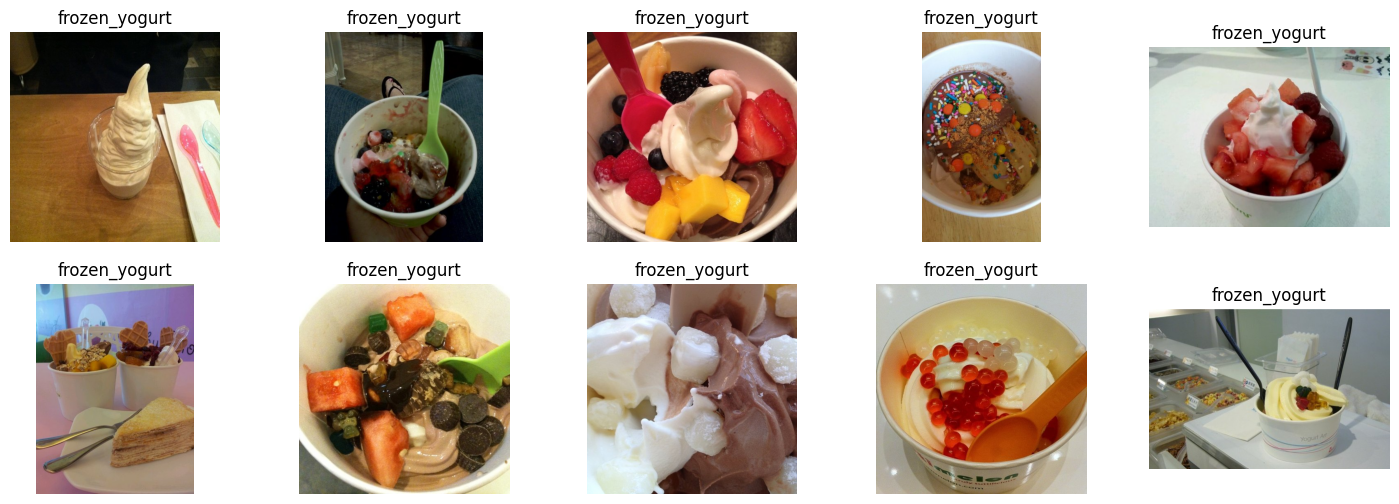

In [10]:
import random
view_random_images(target_dir='101_food_classes_10_percent/train/',
                        target_class=random.choice(class_names),
                   num_images = 10)

In [11]:
import tensorflow as tf

In [12]:
train_data = tf.keras.utils.image_dataset_from_directory('101_food_classes_10_percent/train',
                                                                 image_size = (224, 224),
                                                                 label_mode = 'categorical')

test_data = tf.keras.utils.image_dataset_from_directory('101_food_classes_10_percent/test',
                                                                 image_size = (224, 224),
                                                                 label_mode = 'categorical',
                                                                 shuffle = False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


#### Steps to follow

1.   Create a Model Checkpoint Callback
2.   Create Data Augmentation Layer
3.   Build a headless EfficientNetB7 Model
4.   Compile
5.   Feature extract for 5 epochs


In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2)
], name = 'data_augmentation')

In [14]:
checkpoint_path = "model_checkpoints/checkpoint"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose = 1)


In [15]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = EfficientNetB7(include_top = False)
base_model.trainable = False

inputs = tf.keras.Input(shape = (224, 224, 3), name = 'input_layer')

x = data_augmentation(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)

outputs = Dense(101, activation = 'softmax')(x)

food_vision_mini = tf.keras.Model(
    inputs,
    outputs
)

258076736/258076736 [==============================] - 1s 0us/step


In [16]:
food_vision_mini.compile(loss = 'categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = ['accuracy'])

In [17]:
initial_epochs = 5

history = food_vision_mini.fit(train_data,
                        epochs = initial_epochs,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data) * 0.15,
                        callbacks = [model_checkpoint_callback]
                        )

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.3195 - accuracy: 0.2673
Epoch 1: saving model to model_checkpoints/checkpoint
237/237 [==============================] - 183s 663ms/step - loss: 3.3195 - accuracy: 0.2673 - val_loss: 2.3980 - val_accuracy: 0.4446
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.3072 - accuracy: 0.4453
Epoch 2: saving model to model_checkpoints/checkpoint
237/237 [==============================] - 151s 637ms/step - loss: 2.3072 - accuracy: 0.4453 - val_loss: 2.1117 - val_accuracy: 0.4790
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.9827 - accuracy: 0.5084
Epoch 3: saving model to model_checkpoints/checkpoint
237/237 [==============================] - 194s 817ms/step - loss: 1.9827 - accuracy: 0.5084 - val_loss: 1.9525 - val_accuracy: 0.5126
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 1.8104 - accuracy: 0.5448
Epoch 4: saving model to model_checkpoints/checkpoint

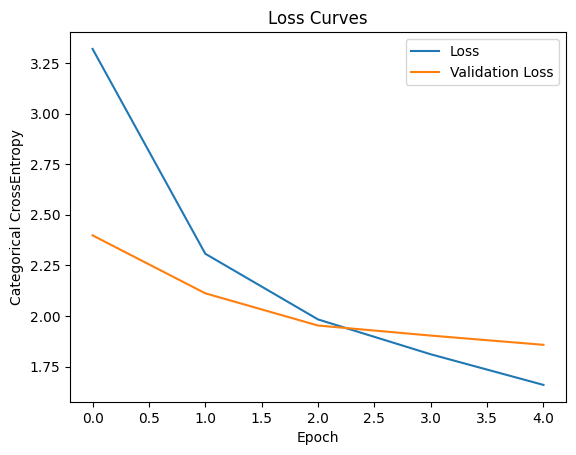

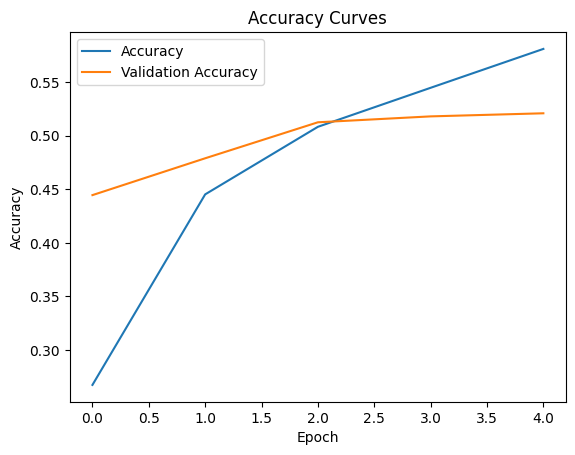

In [18]:
plot_curves(history, 'Categorical CrossEntropy')

In [19]:
food_vision_mini.evaluate(test_data)

790/790 [==============================] - 281s 356ms/step - loss: 1.6659 - accuracy: 0.5627


[1.665946125984192, 0.5627326965332031]

In [20]:
for layer in base_model.layers[-10:]:
  layer.trainable = True

In [21]:
for layer in food_vision_mini.layers[2].layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7f45f8e85360> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f45f8e84670> False
<keras.src.layers.preprocessing.normalization.Normalization object at 0x7f45f8e86920> False
<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f45f8e87070> False
<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f45f8e879a0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f45f8e86ce0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f45f8e86e90> False
<keras.src.layers.core.activation.Activation object at 0x7f45f80aa080> False
<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7f45f80a9ba0> False
<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x7f45f80a97b0> False
<keras.src.layers.core.activation.Activation object at 0x7f45f80aaaa0> False
<keras.src.layers.pooli

In [22]:
food_vision_mini.compile(loss = 'categorical_crossentropy',
                         optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                         metrics = ['accuracy'])

In [23]:
fine_tune_epochs = initial_epochs  + 5

history_fine_tune = food_vision_mini.fit(train_data,
                        epochs = fine_tune_epochs,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = int(0.15 * len(test_data)),
                        initial_epoch = history.epoch[-1]
                        )

Epoch 5/10
237/237 [==============================] - 170s 621ms/step - loss: 1.6077 - accuracy: 0.5921 - val_loss: 1.8863 - val_accuracy: 0.5233
Epoch 6/10
237/237 [==============================] - 141s 593ms/step - loss: 1.5735 - accuracy: 0.6040 - val_loss: 1.8725 - val_accuracy: 0.5312
Epoch 7/10
237/237 [==============================] - 142s 600ms/step - loss: 1.5181 - accuracy: 0.6265 - val_loss: 1.8551 - val_accuracy: 0.5320
Epoch 8/10
237/237 [==============================] - 141s 592ms/step - loss: 1.4879 - accuracy: 0.6290 - val_loss: 1.8478 - val_accuracy: 0.5342
Epoch 9/10
237/237 [==============================] - 140s 588ms/step - loss: 1.4733 - accuracy: 0.6305 - val_loss: 1.8496 - val_accuracy: 0.5318
Epoch 10/10
237/237 [==============================] - 182s 769ms/step - loss: 1.4613 - accuracy: 0.6412 - val_loss: 1.8415 - val_accuracy: 0.5328


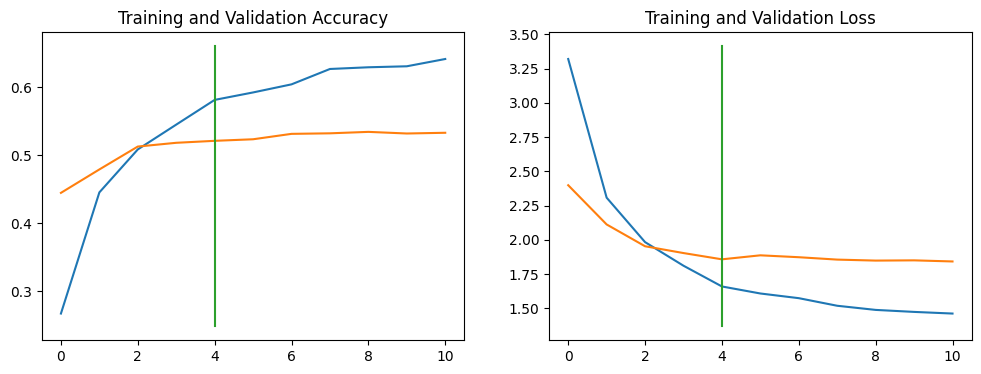

In [25]:
compare_histories(history, history_fine_tune)

In [26]:
loss, accuracy = food_vision_mini.evaluate(test_data)
loss, accuracy

790/790 [==============================] - 283s 358ms/step - loss: 1.6347 - accuracy: 0.5739


(1.6347085237503052, 0.5739405751228333)

In [27]:
pred_probs = food_vision_mini.predict(test_data, verbose=1)

790/790 [==============================] - 279s 347ms/step


In [28]:
pred_probs.shape

(25250, 101)

In [29]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [7.2634276e-03 3.6886163e-04 2.2788387e-02 9.2361997e-06 7.0891503e-05
 1.7249025e-05 2.1926519e-04 3.2240085e-04 5.5111805e-03 1.6075013e-02
 1.3717156e-04 1.0759144e-04 5.2146299e-04 2.2465581e-05 2.7520815e-03
 1.3134725e-03 2.6761407e-05 3.6978956e-05 7.8855234e-04 2.6941288e-03
 2.6924271e-04 1.0665581e-05 4.2780477e-05 9.0898411e-06 9.8906276e-05
 8.9078536e-03 5.8673853e-03 8.9771107e-05 4.0757777e-03 3.8162584e-04
 1.7105802e-05 2.0592039e-05 1.0499070e-04 1.9731787e-04 1.8299958e-03
 4.0221130e-05 4.7053457e-03 1.4347229e-04 1.1858791e-03 3.1907017e-05
 9.1559756e-05 2.9739464e-04 1.5644762e-03 2.0138135e-05 7.1039856e-03
 5.4193224e-04 1.2457798e-03 4.5137313e-06 1.8343449e-03 1.0739023e-02
 8.3199755e-04 3.0387109e-03 4.0340427e-02 5.7269945e-03 3.5565638e-05
 4.0730828e-04 1.8113686e-02 3.1357724e-03 5.4748304e-04 3.6283105e-04
 2.5677502e-05 1.1290773e-03 3.3441556e-03 5.

In [30]:
pred_classes = pred_probs.argmax(axis=1)

In [31]:
pred_classes

array([ 85,   0,   8, ...,   5,  94, 100])

In [32]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5739405940594059

In [34]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [35]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.38      0.17      0.24       250
           1       0.50      0.73      0.60       250
           2       0.59      0.51      0.54       250
           3       0.66      0.55      0.60       250
           4       0.46      0.48      0.47       250
           5       0.41      0.44      0.42       250
           6       0.69      0.73      0.71       250
           7       0.77      0.71      0.74       250
           8       0.32      0.38      0.34       250
           9       0.38      0.72      0.50       250
          10       0.48      0.43      0.45       250
          11       0.50      0.63      0.56       250
          12       0.71      0.51      0.59       250
          13       0.59      0.44      0.50       250
          14       0.53      0.62      0.57       250
          15       0.39      0.27      0.32       250
          16       0.75      0.50      0.60       250
          17       0.43    

In [37]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33        edamame  0.954990
32      dumplings  0.840637
63       macarons  0.820961
51      guacamole  0.805009
45  frozen_yogurt  0.803922

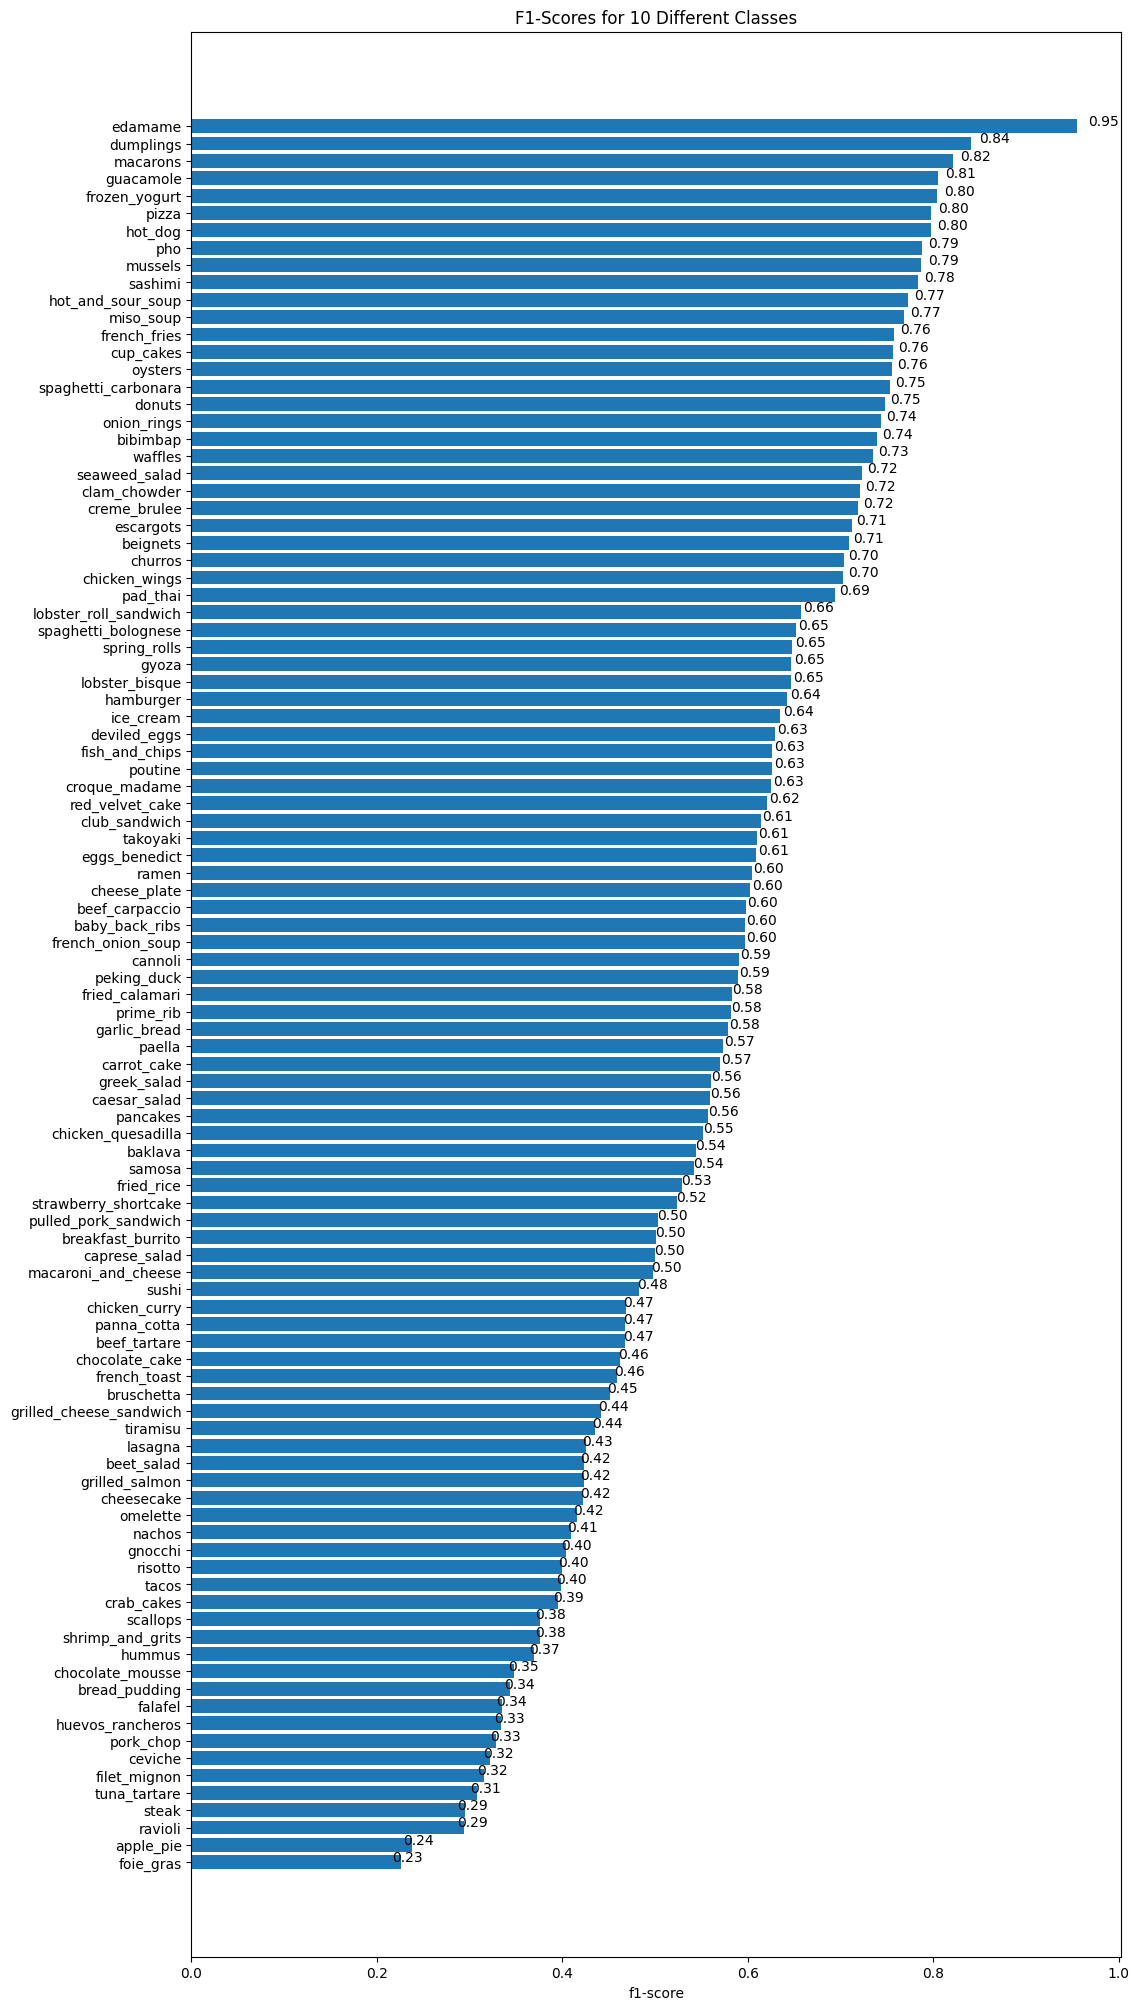

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [41]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

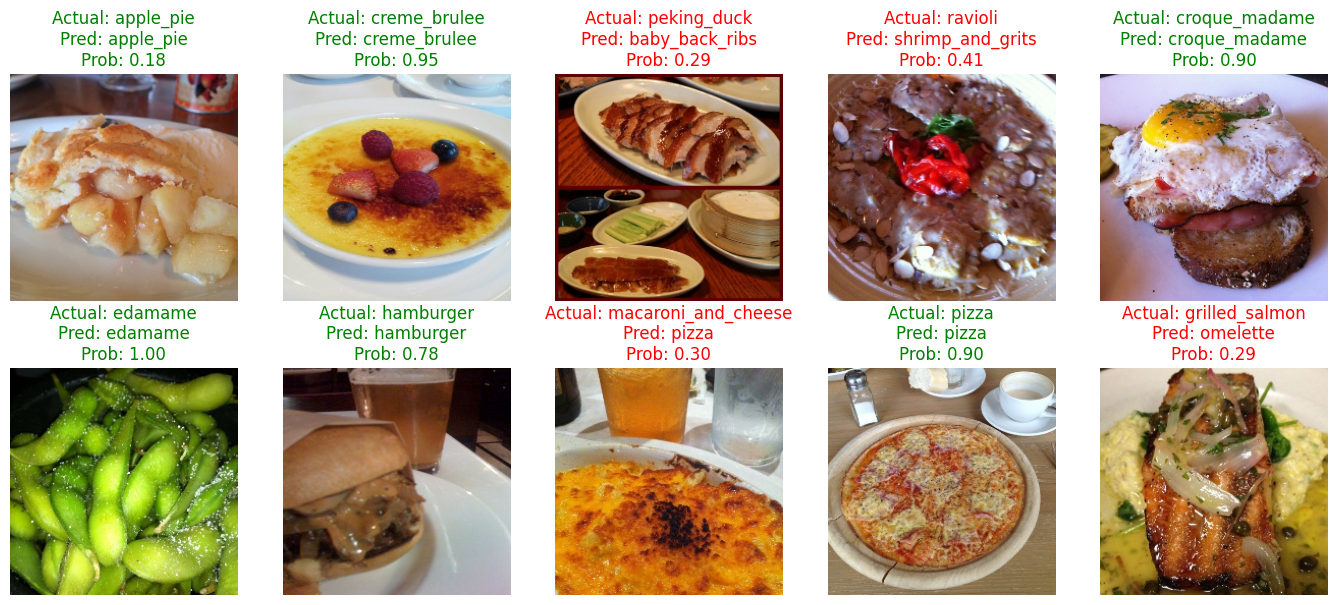

In [45]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 7))
for i in range(10):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir('101_food_classes_10_percent/test' + "/" + class_name))
  filepath = '101_food_classes_10_percent/test/' + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = food_vision_mini.predict(tf.expand_dims(img, axis=0), verbose = 0) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(2, 5, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}\nPred: {pred_class}\nProb: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);